In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import itertools
import scipy
from sklearn.manifold import TSNE
import optuna

In [3]:
dirname_org = "../org+adv_unlim/org"
dirname_adv = "../org+adv_unlim/adv"

In [4]:
def classification_scorer(X, Y):
    sum = 0
    n1 = 0
    for x1, y1 in zip(X, Y):
        n1 += 1
        n2 = 0
        for x2, y2 in zip(X, Y):
            n2 += 1
            if n1 > n2 and y1 != y2:
                dist = ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2) + 1e-53
                sum += 1 / dist

    return sum / (len(Y) * (len(Y) - 1) / 2)

In [5]:
class SupervisedTSNE:
    def __init__(self, X, Y, scorer):
        self.X = X
        self.Y = Y
        self.scorer = scorer
        self.best_score = 1e53
        self.best_model = None

    def __call__(self, trial):
        perplexity = trial.suggest_uniform("perplexity", 5, 50)
        early_exaggeration = trial.suggest_uniform("early_exaggeration", 6, 48)
        init = trial.suggest_categorical("init", ["random", "pca"])

        mapper = TSNE(
            # perplexity=47.502227706507576, 
            # early_exaggeration=9.212850040546918,
            perplexity=perplexity,
            early_exaggeration=early_exaggeration,
            init=init
            )
        embedding = mapper.fit_transform(self.X)
        score = self.scorer(scipy.stats.zscore(embedding), self.Y)

        if self.best_score > score:
            self.best_score = score
            self.best_model = mapper
            
            print(self.best_model)
            title='trial={0}, score={1:.3e}'.format(trial.number, score)
            plt.title(title)
            # plt.scatter(embedding[:, 0], embedding[:, 1], c=np.clip(self.Y, a_max=40, a_min =None), s=3, alpha=0.5)
            plt.scatter(embedding[:, 0], embedding[:, 1], c=self.Y, cmap="tab10", s=3, alpha=0.5)
            plt.colorbar()
            plt.savefig("../org+adv_unlim/tsne_feature_all_MNIST.png", bbox_inches='tight')
            plt.show()      

        return score

In [6]:
# LeNet Model 定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        feature = x
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output, feature

pretrained_model = "checkpoint_model.pth" #事前学習済みMNISTモデル(重みパラメータ)
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [62]:
data = []
label_class = []
label_count = []
for o in range(10):
    for i in range(1, sum(os.path.isfile(os.path.join(dirname_org + "/" + str(o), name)) for name in os.listdir(dirname_org + "/" + str(o))) + 1):
        for a in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
            if os.path.isfile(dirname_adv + "/{}/{}→{}/{}.png".format(o, o, a, i)) == False:
                continue
            # print(np.count_nonzero(img1 - img2))
            if o != a:
                img_o = np.array(Image.open(dirname_org + "/{}/{}.png".format(o, i)).convert("L"))
                img_a = np.array(Image.open(dirname_adv + "/{}/{}→{}/{}.png".format(o, o, a, i)).convert("L"))
                img_o = (img_o == 255) * 2 - 1
                img_a = (img_a == 255) * 2 - 1
                px = np.count_nonzero(img_o - img_a)
                img_o = torch.from_numpy(img_o.astype(np.float32))
                img_o = img_o.unsqueeze(0).unsqueeze(0).to(device)
                output, feature = model(img_o)
                feature = feature.detach().squeeze(0).cpu().numpy()
                b = output.max(1, keepdim=True)[1].item()
                data.append(feature)
                label_class.append(b)
                label_count.append(px)


# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,), (0.5,))
#             ])), 
#         batch_size=1, shuffle=False)

data = np.array(data)
# print(data.shape)
label_class = np.array(label_class)
# print(label)
label_count = np.array(label_count)

In [56]:
# tSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=5000, init="pca")
print("***** start: tSNE(features) *****")
f_decomp = tsne.fit_transform(data)


# end2 = time.time() 
# elapsed_time =  end2 - end1
# print (f"----- elapsed_time:{elapsed_time:4.2f}[sec] -----")

***** start: tSNE(features) *****


/home/hoge/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/hoge/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



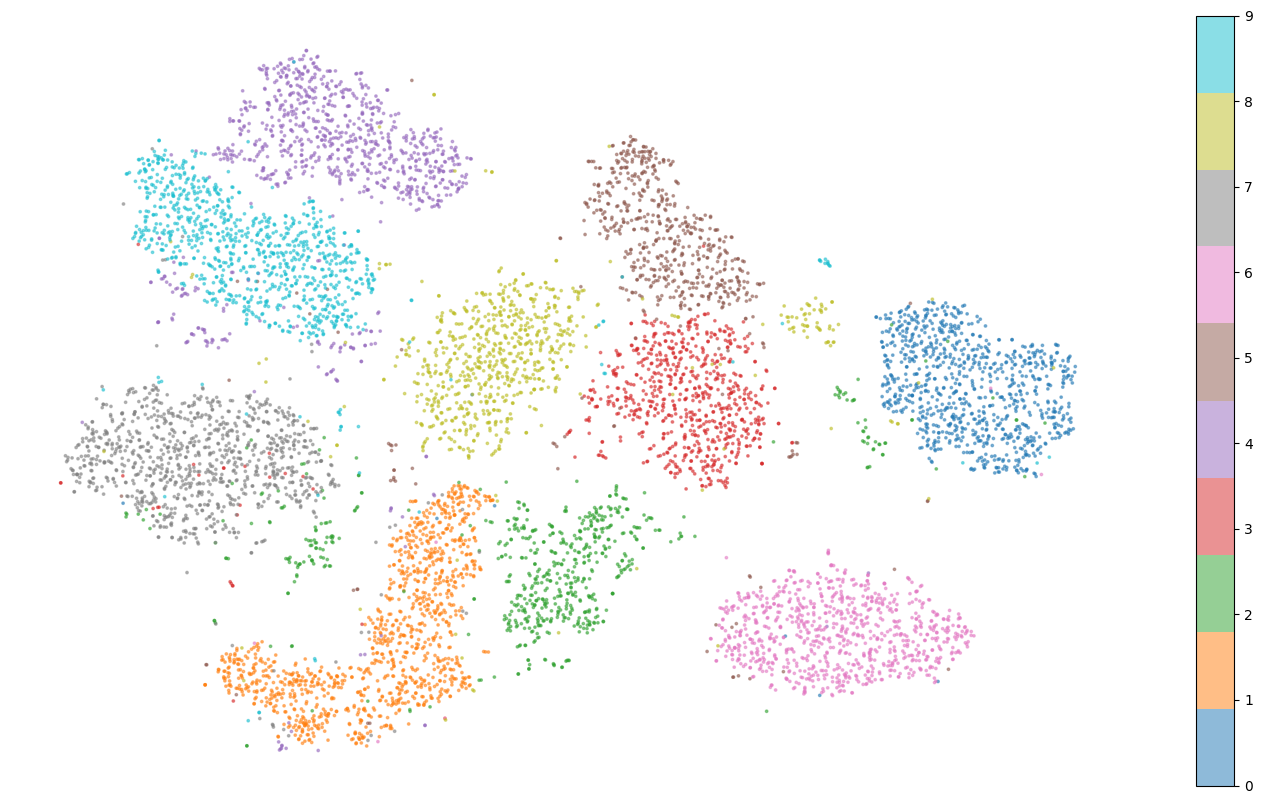

In [65]:
# plot features
plt.figure(figsize=(18, 10))
plt.scatter(f_decomp[:, 0], f_decomp[:, 1],
            c=np.clip(label_class, a_max=40, a_min =None),
            s=3,cmap="tab10", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.savefig("../org+adv_unlim/tsne_feature_all_class_2d.png".format(o), bbox_inches='tight')
plt.show()

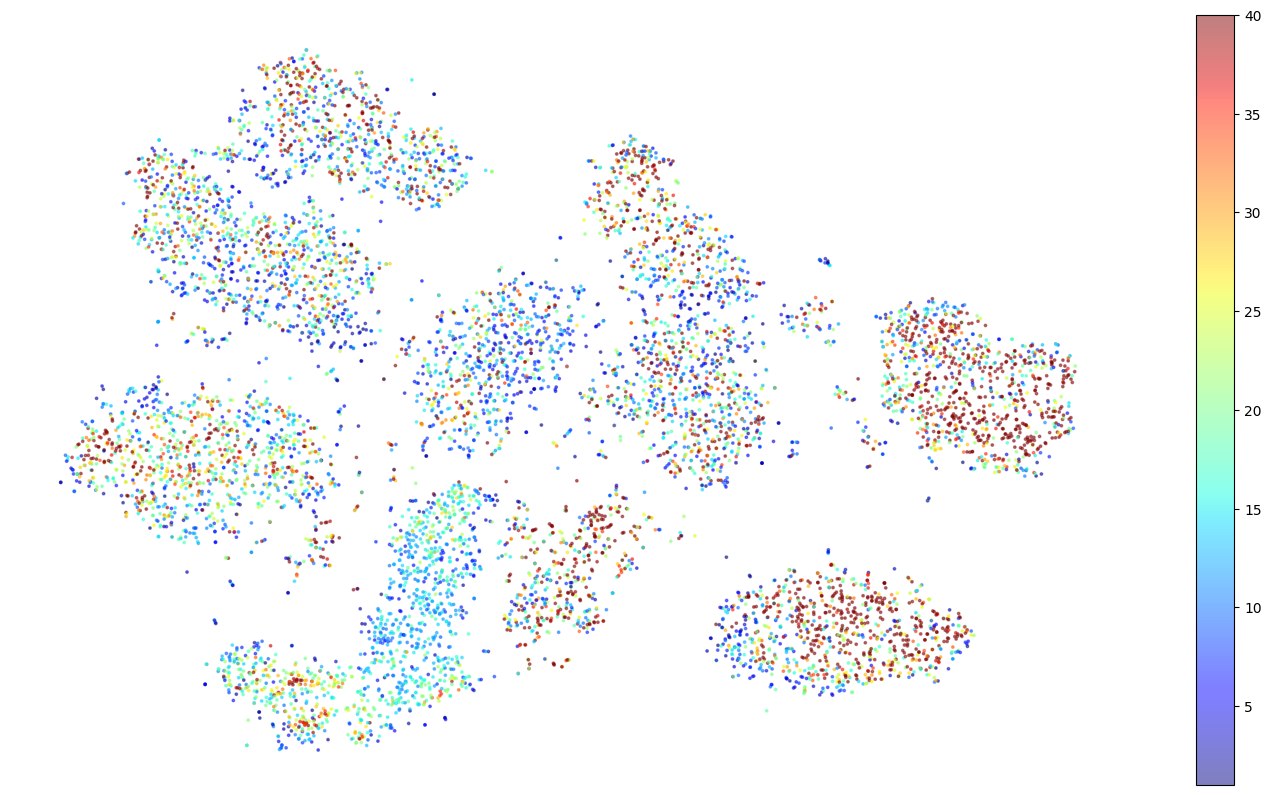

In [66]:
plt.figure(figsize=(18, 10))
plt.scatter(f_decomp[:, 0], f_decomp[:, 1],
            c=np.clip(label_count, a_max=40, a_min =None),
            s=3,cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.savefig("../org+adv_unlim/tsne_feature_all_count_2d.png".format(o), bbox_inches='tight')
plt.show()

In [8]:
digits3d = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=5000)
f_decomp3d = digits3d.fit_transform(data)

/home/hoge/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hoge/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


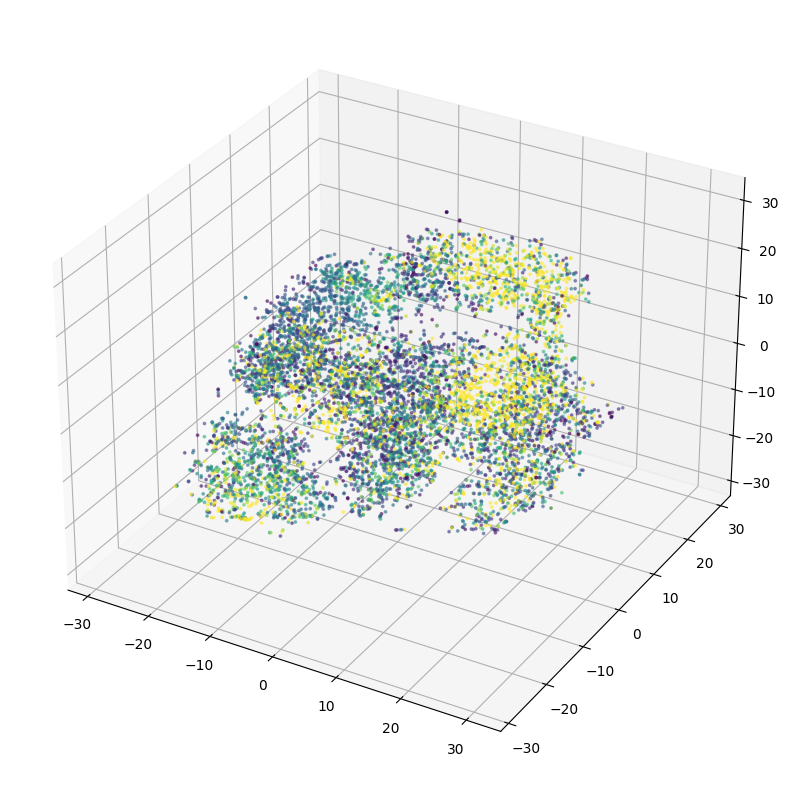

In [38]:
# %matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(f_decomp3d[:, 0], f_decomp3d[:, 1], f_decomp3d[:, 2],
            c=np.clip(label, a_max=40, a_min =None),
            s=3, alpha=0.5)
# plt.colorbar()
# ax.savefig("../org+adv_unlim/tsne_feature_all_flipped_count2_3d.png".format(o), bbox_inches='tight')
plt.show()

In [83]:
# -*- coding: utf-8 -*-
import plotly.graph_objects as go
from itertools import  starmap

# mode='makers'を指定しないと点の間に線が引かれる
fig = go.Figure(data=[go.Scatter3d(x=f_decomp3d[:, 0],y=f_decomp3d[:, 1],z=f_decomp3d[:, 2],mode='markers',marker=dict(
    size=2
    ,color = np.clip(label_class, a_max=40, a_min =None)
    ,colorscale = "Turbo",
    colorbar=dict(thickness=20)
    # ,symbol= result_symbol
))])
# set all symbols in fig
fig.write_html("../org+adv_unlim/tsne_feature_all_class_3d.html".format(o))
fig.show()

In [84]:
# -*- coding: utf-8 -*-
import plotly.graph_objects as go
from itertools import  starmap

# mode='makers'を指定しないと点の間に線が引かれる
fig = go.Figure(data=[go.Scatter3d(x=f_decomp3d[:, 0],y=f_decomp3d[:, 1],z=f_decomp3d[:, 2],mode='markers',marker=dict(
    size=2
    ,color = np.clip(label_count, a_max=40, a_min =None)
    ,colorscale = "Turbo",
    colorbar=dict(thickness=20)
    # ,symbol= result_symbol
))])
fig.write_html("../org+adv_unlim/tsne_feature_all_count_3d.html".format(o))
fig.show()